## **Neural Style Transfer**

In [ ]:
import torch
from torchvision import transforms, models
from torch import optim

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

**Device and model**

In [ ]:
# Device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Get the model

model_weights = models.VGG19_Weights.DEFAULT
model = models.vgg19(weights=model_weights)
model = model.features
model.to(device)
next(model.parameters()).is_cuda

True

In [ ]:
# Freeze the layer parameters

for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Model summary

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

summary(model=model, 
        input_size=(1, 3, 512, 512),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=22) 

Layer (type:depth-idx)                   Input Shape            Output Shape           Param #                Trainable
Sequential                               [1, 3, 512, 512]       [1, 512, 16, 16]       --                     False
├─Conv2d: 1-1                            [1, 3, 512, 512]       [1, 64, 512, 512]      (1,792)                False
├─ReLU: 1-2                              [1, 64, 512, 512]      [1, 64, 512, 512]      --                     --
├─Conv2d: 1-3                            [1, 64, 512, 512]      [1, 64, 512, 512]      (36,928)               False
├─ReLU: 1-4                              [1, 64, 512, 512]      [1, 64, 512, 512]      --                     --
├─MaxPool2d: 1-5                         [1, 64, 512, 512]      [1, 64, 256, 256]      --                     --
├─Conv2d: 1-6                            [1, 64, 256, 256]      [1, 128, 256, 256]     (73,856)               False
├─ReLU: 1-7                              [1, 128, 256, 256]     [1, 128, 256,

**Data setup**

In [ ]:
# Process data functions

def preprocess(img_path):

  image = Image.open(img_path).convert('RGB')
  imsize = 256 if torch.cuda.is_available() else 512
  transform = transforms.Compose([
      transforms.Resize((imsize, imsize)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
  ])

  image = transform(image)
  image = image.unsqueeze(dim=0)

  return image.to(device)


def deprocess(image): # def show_image
  
  image = image.clone()
  image = image.squeeze(0)
  image = image.permute(1,2,0)
  image = image.to('cpu').numpy()
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1)

  return image

In [ ]:
# Preprocess and deprocess data

content_p = preprocess('content1.jpg')
style_p = preprocess('style1.jpg')

content_d = deprocess(content_p)
style_d = deprocess(style_p)

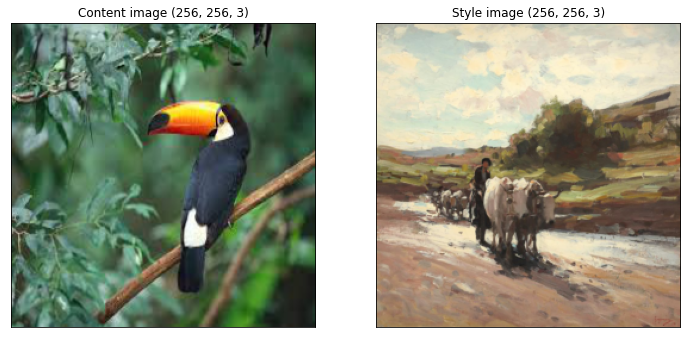

In [ ]:
# Visualise content/style images

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax1.imshow(content_d)
ax1.set(title=f'Content image {content_d.shape}',
        xticks=[],
        yticks=[])

ax2.imshow(style_d)
ax2.set(title=f'Style image {style_d.shape}',
        xticks=[],
        yticks=[]);


**Get features and gram matrix**


<font size='2'>```img src:```[A Neural Algorithm of Artistic Style Paper](https://arxiv.org/pdf/1508.06576.pdf)</font>


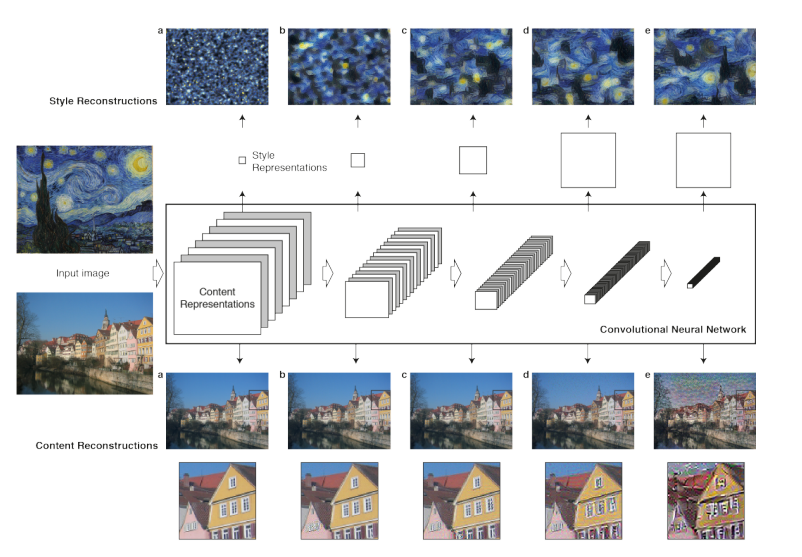


<font size='2'>```img src:```[Introduction to Neural Style Transfer using Deep Learning & TensorFlow 2](https://cloudxlab.com/assessment/displayslide/5648/calculating-style)</font>

<img src='https://cxl-web-prod-uploads.s3.amazonaws.com/public/pagedown-uploads/ea8b739627d743145c9e1fda0310532d59dbb787.png'>

In [ ]:
# Features and gram_matrix functions

def get_features(image, model):

  features = {}
  layers = {
    '0': 'layer_1',
    '5': 'layer_2',
    '10': 'layer_3',
    '19': 'layer_4',
    '28': 'layer_5'
    }

  x = image
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x
  return features


def gram_matrix(image_tensor):

  b, c, h, w = image_tensor.size()
  image_tensor = image_tensor.view(c, h*w)
  gram = torch.mm(image_tensor, image_tensor.t())

  return gram

In [ ]:
# Get features

content_f = get_features(content_p, model)
style_f = get_features(style_p, model)

In [ ]:
# Get the style gram matrix

style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

**Content/style loss**

In [ ]:
# Loss functions

def content_loss(target, content):

  loss = torch.mean((target - content) ** 2)

  return loss


def style_loss(target_features, style_grams):

  loss = 0
  for layer in target_features:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss = 0.2 * torch.mean((target_gram - style_gram) ** 2)
    loss += layer_loss/(c*h*w)

  return loss


def total_loss(c_loss, s_loss, alpha, beta):

  loss = alpha * c_loss + beta * s_loss
  return loss

**Perform style transfer**

In [ ]:
# Get the target image features

target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target, model)

In [ ]:
# Hyperparameters

optimizer = optim.Adam([target], lr=3e-2)

#α and β are the weighting factors for content and style reconstruction
alpha_param = 1
beta_param = 1e3

epochs = 1000

In [ ]:
# Style transfer loop

for i in range(epochs):
  target_f = get_features(target, model)

  c_loss = content_loss(target_f['layer_4'], content_f['layer_4'])
  s_loss = style_loss(target_f, style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha_param, beta_param)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if (i+1) % 100 == 0:
    print(f'Total loss at epoch {i+1} is {t_loss}')

results = deprocess(target.detach())

Total loss at epoch 100 is 537.357177734375
Total loss at epoch 200 is 432.93212890625
Total loss at epoch 300 is 379.3022155761719
Total loss at epoch 400 is 337.8475646972656
Total loss at epoch 500 is 306.244384765625
Total loss at epoch 600 is 270.278076171875
Total loss at epoch 700 is 255.970458984375
Total loss at epoch 800 is 231.19265747070312
Total loss at epoch 900 is 209.21340942382812
Total loss at epoch 1000 is 201.30502319335938


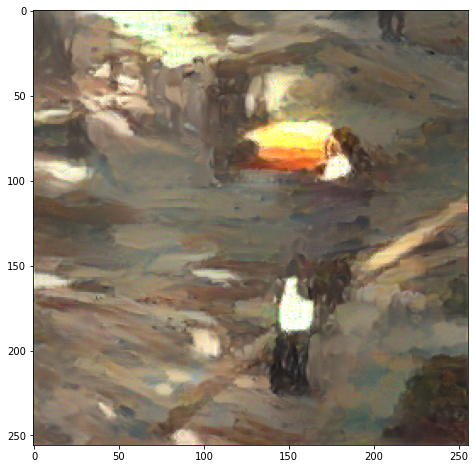

In [ ]:
# Visualise target image

plt.figure(figsize=(10, 8))
plt.imshow(results);